# Separación de las imágenes y preparación del dataset final

## Librerías

In [3]:
import rasterio as rt
import cv2
from pathlib import Path
import os
from PIL import Image as Im
import numpy as np
import shutil

## Lectura de los datos

In [47]:
# directorio datos:

data_directory = Path.cwd() / 'spatial_data'
rgb_filename = 'merged_raster_preprocessed.png'
mask_filename = 'badajoz_multiclass_mask.png'
rgb_path = data_directory / rgb_filename
mask_path = data_directory / mask_filename

In [48]:
# Lectura de imagen RGB con open cv

rgb_image = cv2.imread(rgb_path, 1) # El flag 1 indica que la imagen se lea como RGB

In [49]:
# Para leer la imagen multimáscara, es preferible utilizar pillow

Im.MAX_IMAGE_PIXELS = None # Eliminar la protección contra ataques decompression bomb DOS
mask_image = Im.open(mask_path)
mask_image_np = np.array(mask_image) # Transformar a array de numpy
np.unique(mask_image_np) # valores únicos para comprobar que se ha cargado bien

array([0, 1, 2, 3])

## Obtención de cuadrados

### Imagen RGB

In [50]:
square_size = 512

In [51]:
height, width, _ = rgb_image.shape

In [52]:
# Crear una carpeta para guardar las imágenes
os.makedirs('dataset/raw/features', exist_ok=True)

# Dividir la imagen en pequeños cuadrados
for y in range(0, height, square_size):
    for x in range(0, width, square_size):
        # Obtener el bloque de la imagen
        block = rgb_image[y:y+square_size, x:x+square_size]
        
        # Guardar el bloque
        block_filename = f'dataset/raw/features/square_{x}_{y}.png'
        cv2.imwrite(block_filename, block)

### Máscara

In [56]:
height, width = mask_image_np.shape

In [57]:
# Crear una carpeta para guardar las máscaras
os.makedirs('dataset/raw/labels', exist_ok=True)

# Dividir la máscara en pequeños cuadrados
for y in range(0, height, square_size):
    for x in range(0, width, square_size):
        # Obtener el bloque de la máscara
        block = mask_image_np[y:y+square_size, x:x+square_size]
        
        # Guardar el bloque
        block_filename = f'dataset/raw/labels/mask_{x}_{y}.png'
        cv2.imwrite(block_filename, block)

Vamos a comprobar que las máscaras son correctas, ya que al guardarlas como escala de grises, son indistingibles al ojo humano.

Vemos que los valores de la máscara están comprendidos entre 0 y 3

In [59]:
# Ruta a las imágenes de las máscaras
image_folder = 'dataset/raw/labels'

# Inicializar un conjunto para almacenar los valores únicos
unique_values = set()

# Iterar sobre todos los archivos en la carpeta
for filename in os.listdir(image_folder):
    if filename.endswith('.png'):
        # Ruta completa al archivo de la imagen
        image_path = os.path.join(image_folder, filename)
        
        # Cargar la imagen
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        # Asegurarse de que la imagen se cargó correctamente
        if image is None:
            print(f'Error al cargar la imagen {image_path}')
            continue
        
        # Actualizar el conjunto de valores únicos
        unique_values.update(np.unique(image))

# Convertir el conjunto a una lista y ordenarlo (opcional)
unique_values = sorted(unique_values)

print(f'Valores únicos en todas las imágenes: {unique_values}')


Valores únicos en todas las imágenes: [0, 1, 2, 3]


## Limpieza de datos

### Eliminación de imágenes y máscaras rectangulares

En primer lugar, vamos a eliminar las imágenes que no tengan la resolución necesaria. Estas se corresponden a los límites sur y este de badajoz y se debe a que el tamaño de las nuevas imágenes (500 p) no es múltiplo del ancho o del largo de la imagen original.

In [60]:
print(f'resolución original: {rgb_image.shape[:-1]} píxeles')

resolución original: (17281, 23085) píxeles


In [61]:
# Directorio de imágenes y máscaras

images_path = Path.cwd() / 'dataset/raw/features'
masks_path = Path.cwd() / 'dataset/raw/labels'

image_files_list = list(images_path.glob('*.png'))
mask_files_list = list(masks_path.glob('*.png'))

print(f'nº imágenes: {len(image_files_list)}\nnº máscaras: {len(mask_files_list)}')

nº imágenes: 1564
nº máscaras: 1564


Para optimizar la búsqueda, vamos a utilizar los nombres de las imágenes, ya que tienen información del área de la imagen original a la que pertenecen.

In [62]:
# Obtener parámetros de la imagen original
X_PX, Y_PX = rgb_image.shape[:-1]

In [63]:
to_drop_dict = {'Image':[],'Mask':[]}

for image, mask in zip(image_files_list, mask_files_list):
    
    # Obtengo el fichero con image.parts[-1], me quedo con el nombre sin la extensión .png y separo por _ para obtener los metadatos
    y, x = image.parts[-1].split(sep='.')[0].split(sep='_')[1:]

    # Obtengo los márgenes horizontales y verticales de cada imagen

    x_margin = X_PX - int(x)
    y_margin = Y_PX - int(y)

    # Si el margen es menor al tamaño del cuadrado, entonces se trata de un rectángulo de lado menor a 500

    if (x_margin < square_size) | (y_margin < square_size):

        to_drop_dict['Image'].append(image)
        to_drop_dict['Mask'].append(mask)

In [64]:
def to_drop_update(feats, labels, dict):
    '''Actualización de las listas de elementos válidos a partir del diccionario de elementos a eliminar'''

    keys = list(dict.keys())
    drop_images = dict[keys[0]]
    drop_labels = dict[keys[1]]

    valid_feats = list()
    valid_labels = list()

    for image, mask in zip(feats, labels):

        if not(image in drop_images) and not(mask in drop_labels):
            valid_feats.append(image)
            valid_labels.append(mask)

    return (valid_feats, valid_labels)

In [65]:
valid_images, valid_masks = to_drop_update(image_files_list, mask_files_list, to_drop_dict)

### Eliminación de máscaras de valor nulo

Las imagenes que no tienen ningún tipo de uso no tendrán ninguna utilidad.

In [66]:
to_drop_dict = {'Image':[],'Mask':[]}

for image, mask in zip(valid_images, valid_masks):

    mask_image = np.array(Im.open(mask))

    if not(mask_image.max()):

        to_drop_dict['Image'].append(image)
        to_drop_dict['Mask'].append(mask)

In [67]:
valid_images, valid_masks = to_drop_update(valid_images, valid_masks, to_drop_dict)

### Eliminación de máscaras para balanceo de clases

Si se va a utilizar un modelo de segmentación, las imágenes que no contengan píxeles solares ni de invernadero introducirán un enorme desbalanceo.

In [68]:
id_solar = 2 # Etiqueta que representa pixel solar
id_grhouse = 1 # Etiqueta que representa pixel de invernadero
for_segmentation = True # Flag para indicar si el dataset servirá para entrenar un modelo de segmentación

In [69]:
if for_segmentation:
    
    to_drop_dict = {'Image':[],'Mask':[]}

    for image, mask in zip(valid_images, valid_masks):

        mask_image = np.array(Im.open(mask))

        if (not id_solar in mask_image) and (not id_grhouse in mask_image):

            to_drop_dict['Image'].append(image)
            to_drop_dict['Mask'].append(mask)

In [70]:
if for_segmentation:
    valid_images, valid_masks = to_drop_update(valid_images, valid_masks, to_drop_dict)

Ya tenemos el diccionario con las imágenes y máscaras que no vamos a utilizar. Vamos a copiar y pegar todos los archivos que necesitamos a una carpeta.

In [71]:
# Directorios de destino

clean_images_path = Path.cwd() / 'dataset/clean/features'
clean_masks_path = Path.cwd() / 'dataset/clean/labels'

In [72]:
# Creación de directorios (descomentar)

os.makedirs(clean_images_path, exist_ok=True)
os.makedirs(clean_masks_path, exist_ok=True)

In [73]:
for image, mask in zip(valid_images, valid_masks):
    shutil.copy(image,clean_images_path)
    shutil.copy(mask,clean_masks_path)

In [5]:
# Volver a comprobar que los valores permanecen

# Ruta a las imágenes de las máscaras
image_folder = 'dataset/clean/labels'

# Inicializar un conjunto para almacenar los valores únicos
unique_values = set()

# Iterar sobre todos los archivos en la carpeta
for filename in os.listdir(image_folder):
    if filename.endswith('.png'):
        # Ruta completa al archivo de la imagen
        image_path = os.path.join(image_folder, filename)
        
        # Cargar la imagen
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        # Asegurarse de que la imagen se cargó correctamente
        if image is None:
            print(f'Error al cargar la imagen {image_path}')
            continue
        
        # Actualizar el conjunto de valores únicos
        unique_values.update(np.unique(image))

# Convertir el conjunto a una lista y ordenarlo (opcional)
unique_values = sorted(unique_values)

print(f'Valores únicos en todas las imágenes: {unique_values}')


Valores únicos en todas las imágenes: [0, 1, 2, 3]


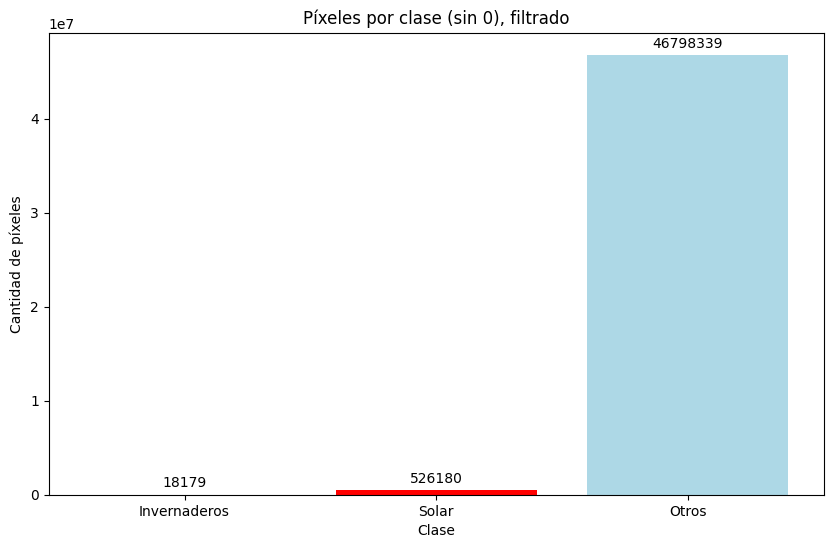

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Ruta a las imágenes PNG
images_path = 'dataset/clean/labels'

# Inicializar un contador para los píxeles
pixel_counter = Counter()

# Leer todas las imágenes PNG en la ruta especificada
for filename in os.listdir(images_path):
    if filename.endswith('.png'):
        image_path = os.path.join(images_path, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Leer la imagen en modo de escala de grises
        unique, counts = np.unique(image, return_counts=True)
        pixel_counter.update(dict(zip(unique, counts)))

# Eliminar los píxeles con valor 0
if 0 in pixel_counter:
    del pixel_counter[0]

# Colores asociados a cada clase
colors = ['#8CFF32', '#ADD8E6', '#FF0000']  # Amarillo, rojo, azul

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(pixel_counter.keys(), pixel_counter.values(), color=colors)  # Usar los colores definidos
plt.xlabel('Clase')
plt.ylabel('Cantidad de píxeles')
plt.title('Píxeles por clase (sin 0), filtrado')
plt.xticks(ticks=[1, 2, 3], labels=['Invernaderos', 'Solar', 'Otros'])  # Etiquetas de las clases

# Añadir etiquetas con los valores numéricos encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # Desplazamiento del texto en píxeles
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()



In [8]:
import os
import numpy as np
from PIL import Image
from collections import defaultdict

# Ruta de la carpeta que contiene las imágenes
carpeta_imagenes = 'dataset/clean/labels'

# Diccionario para almacenar el conteo de píxeles por clase
conteo_pixeles = defaultdict(lambda: {1: 0, 2: 0, 3: 0})

# Listas para almacenar las imágenes con más píxeles para cada clase
imagenes_mas_pixeles = {1: [], 2: [], 3: []}

# Recorremos todos los archivos en la carpeta de imágenes
for archivo in os.listdir(carpeta_imagenes):
    if archivo.endswith('.png'):
        # Abrimos la imagen
        imagen_path = os.path.join(carpeta_imagenes, archivo)
        imagen = Image.open(imagen_path)
        # Convertimos la imagen a un array de numpy
        array_imagen = np.array(imagen)
        
        # Contamos los píxeles de cada clase (1, 2, 3)
        conteo_clase_1 = np.sum(array_imagen == 1)
        conteo_clase_2 = np.sum(array_imagen == 2)
        conteo_clase_3 = np.sum(array_imagen == 3)
        
        # Guardamos el conteo de píxeles en el diccionario
        conteo_pixeles[archivo] = {1: conteo_clase_1, 2: conteo_clase_2, 3: conteo_clase_3}

# Encontramos las 3 imágenes con más píxeles para cada clase
for clase in [1, 2, 3]:
    # Ordenamos las imágenes por el número de píxeles para la clase actual en orden descendente
    ordenado_por_clase = sorted(conteo_pixeles.items(), key=lambda x: x[1][clase], reverse=True)
    # Guardamos las 3 imágenes con más píxeles para la clase actual
    imagenes_mas_pixeles[clase] = [item[0] for item in ordenado_por_clase[:3]]

# Imprimimos los resultados
for clase in [1, 2, 3]:
    print(f'Imágenes con más píxeles para la clase {clase}:')
    for imagen in imagenes_mas_pixeles[clase]:
        print(f'  {imagen} con {conteo_pixeles[imagen][clase]} píxeles')
    print()


Imágenes con más píxeles para la clase 1:
  mask_12800_4608.png con 2957 píxeles
  mask_4608_6656.png con 2206 píxeles
  mask_12288_5120.png con 1516 píxeles

Imágenes con más píxeles para la clase 2:
  mask_4096_7680.png con 36903 píxeles
  mask_14848_3072.png con 32882 píxeles
  mask_9216_11776.png con 31293 píxeles

Imágenes con más píxeles para la clase 3:
  mask_14848_8192.png con 262141 píxeles
  mask_5632_6144.png con 262138 píxeles
  mask_5632_8192.png con 262137 píxeles




Archivos encontrados para la clase Invernaderos:
dataset/clean/features\square_12288_5120.png
dataset/clean/features\square_12800_4608.png
dataset/clean/features\square_4608_6656.png

Archivos encontrados para la clase Solar:
dataset/clean/features\square_14848_3072.png
dataset/clean/features\square_4096_7680.png
dataset/clean/features\square_9216_11776.png

Archivos encontrados para la clase Otros:
dataset/clean/features\square_14848_8192.png
dataset/clean/features\square_5632_6144.png
dataset/clean/features\square_5632_8192.png


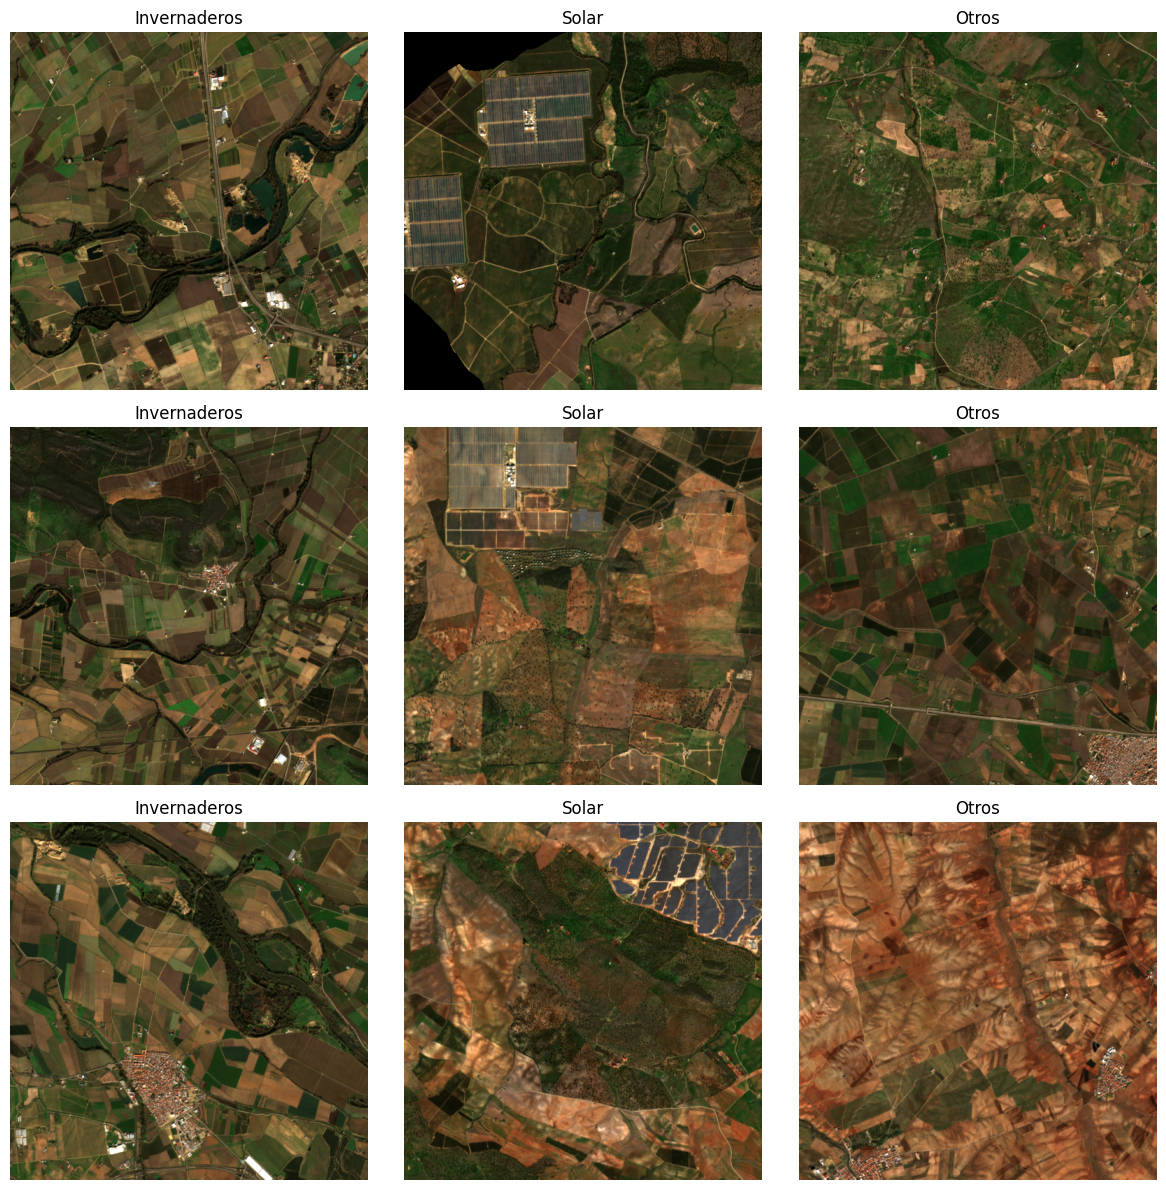

In [17]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Definir la ruta de la carpeta que contiene las imágenes de características
carpeta_features = 'dataset/clean/features'

# Definir el objeto de imágenes con más píxeles por clase
imagenes_mas_pixeles = {
    'Invernaderos': [
        'square_12800_4608.png',
        'square_4608_6656.png',
        'square_12288_5120.png'
    ],
    'Solar': [
        'square_4096_7680.png',
        'square_14848_3072.png',
        'square_9216_11776.png'
    ],
    'Otros': [
        'square_14848_8192.png',
        'square_5632_6144.png',
        'square_5632_8192.png'
    ]
}

# Buscar archivos en la carpeta de características que contengan alguno de los sufijos
def buscar_archivos_con_sufijos(carpeta_features, sufijos):
    archivos_encontrados = []
    for archivo in os.listdir(carpeta_features):
        if any(sufijo in archivo for sufijo in sufijos):
            archivos_encontrados.append(os.path.join(carpeta_features, archivo))
    return archivos_encontrados

# Obtener los archivos que coinciden con los sufijos para cada clase
archivos_por_clase = {}
for clase, imagenes in imagenes_mas_pixeles.items():
    archivos_por_clase[clase] = buscar_archivos_con_sufijos(carpeta_features, imagenes)

# Imprimir los archivos encontrados
for clase, archivos in archivos_por_clase.items():
    print(f'\nArchivos encontrados para la clase {clase}:')
    for archivo in archivos:
        print(archivo)

# Función para mostrar imágenes en una cuadrícula por clase
def mostrar_imagenes_por_clase(archivos_por_clase, filas=3, columnas=3):
    # Crear la figura con una cuadrícula
    fig, axs = plt.subplots(filas, columnas, figsize=(12, 12))
    
    # Lista de clases ordenadas por columna
    clases = list(archivos_por_clase.keys())
    
    for i, clase in enumerate(clases):
        for j, archivo in enumerate(archivos_por_clase[clase]):
            if j >= filas:
                break  # Si hay más imágenes que el número de filas, solo tomamos las primeras
            
            # Obtener la imagen
            imagen = Image.open(archivo)
            # Ubicación en la cuadrícula
            axs[j, i].imshow(imagen, cmap='gray')
            axs[j, i].set_title(clase)
            axs[j, i].axis('off')

    # Configurar títulos de columnas
    for i, clase in enumerate(clases):
        axs[-1, i].set_xlabel(clase, fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Mostrar imágenes en una cuadrícula por clase
mostrar_imagenes_por_clase(archivos_por_clase)
